###Import data

In [ ]:
import pandas as pd

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving compas-scores-two-years.csv to compas-scores-two-years.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['compas-scores-two-years.csv']))

###Preprocessing

In [ ]:
df = df.loc[df["race"].isin(["African-American", "Caucasian"])]
df["race"].replace(['African-American', 'Caucasian'],[0, 1], inplace=True)
df["sex"] = pd.get_dummies(df["sex"])["Female"]
le={"Low":0,"Medium":1,"High":2}
df["score_text"]= df["score_text"].replace(le)
df.columns.values

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

array(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex',
       'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_case_number', 'c_offense_date', 'c_arrest_date',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc',
       'is_recid', 'r_case_number', 'r_charge_degree',
       'r_days_from_arrest', 'r_offense_date', 'r_charge_desc',
       'r_jail_in', 'r_jail_out', 'violent_recid', 'is_violent_recid',
       'vr_case_number', 'vr_charge_degree', 'vr_offense_date',
       'vr_charge_desc', 'type_of_assessment', 'decile_score.1',
       'score_text', 'screening_date', 'v_type_of_assessment',
       'v_decile_score', 'v_score_text', 'v_screening_date', 'in_custody',
       'out_custody', 'priors_count.1', 'start', 'end', 'event',
       'two_year_recid'], dtype=object)

In [ ]:
Z = pd.DataFrame(df["race"])
y = df["two_year_recid"]
X = pd.DataFrame(df, columns=["race","age","priors_count","juv_fel_count","juv_misd_count","juv_other_count",'decile_score','score_text',"sex"])

In [ ]:
!git clone https://github.com/sony/nnabla-examples.git
%cd nnabla-examples/responsible_ai/prejudice_remover_regularizer
!pip install nnabla-ext-cuda114

Cloning into 'nnabla-examples'...
remote: Enumerating objects: 8716, done.
remote: Counting objects: 100% (1269/1269), done.
remote: Compressing objects: 100% (570/570), done.
remote: Total 8716 (delta 718), reused 1149 (delta 667), pack-reused 7447
Receiving objects: 100% (8716/8716), 295.83 MiB | 35.68 MiB/s, done.
Resolving deltas: 100% (4623/4623), done.
Checking out files: 100% (1642/1642), done.
/content/nnabla-examples/responsible_ai/prejudice_remover_regularizer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 114.8 MB 53 kB/s 
     |████████████████████████████████| 18.8 MB 52.0 MB/s 
     |████████████████████████████████| 1.1 MB 49.9 MB/s 
     |████████████████████████████████| 132 kB 73.5 MB/s 
     |████████████████████████████████| 79 kB 9.1 MB/s 
     |████████████████████████████████| 10.1 MB 59.9 MB/s 
     |████████████████████████████████| 140 kB 66.0 MB/s 
  Attempting uninsta

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import nnabla as nn
from nnabla.logger import logger
import nnabla.functions as F
import nnabla.parametric_functions as PF
import nnabla.solvers as S
from nnabla.utils.data_iterator import data_iterator
from nnabla.utils.data_source import DataSource
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import Markdown

from utils import *

In [ ]:
nn.clear_parameters()

###Data preparation

In [ ]:
(X_train, X_test, y_train, y_test, Z_train, Z_test) = train_test_split(X, y, Z, test_size=0.3, stratify=y, random_state=7)

scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(X_train)
X_test = scale_orig.fit_transform(X_test)

In [ ]:
class dataset(DataSource):
    def __init__(self,features, labels, senstive_attribute, shuffle=False):
        super(dataset, self).__init__(shuffle=shuffle)
        self.x = features
        self.y = labels.reshape(-1, 1)
        self.z = senstive_attribute
        self._size = self.y.size
        self._variables = ('x', 'y', 'z')
        
    def _get_data(self, idx):
        return self.x[idx], self.y[idx], self.z[idx]

trainset = dataset(X_train, y_train.to_numpy(), Z_train.to_numpy(), shuffle=True)
testset = dataset(X_test, y_test.to_numpy(), Z_test.to_numpy())

batchsize = 32
test_batchsize = X_test.shape[0]

trainloader = data_iterator(trainset, batch_size=batchsize)
testloader = data_iterator(testset, batch_size=test_batchsize)

In [ ]:
from nnabla.ext_utils import get_extension_context
context = "cudnn" # for cpu set context as 'cpu'
device_id = 0
ctx = get_extension_context(context, device_id=device_id)
nn.set_default_context(ctx)

In [ ]:
n_feature = nn.Variable((batchsize, 9))
n_label = nn.Variable((batchsize, 1))
n_senstive = nn.Variable((batchsize, 1))

test_feature = nn.Variable((test_batchsize, 9))
test_label = nn.Variable((test_batchsize, 1))
test_senstive = nn.Variable((test_batchsize, 1))

###Classifier Network

In [ ]:
def Classifier(features_n, n_hidden=32, p_dropout=0.2,train=True):
    with nn.parameter_scope('classifier'):
        l1 = PF.affine(features_n, n_hidden, name='l1')
        l1 = F.relu(l1)
        if (train):
            l1 = F.dropout(l1,p_dropout)
        l2 = PF.affine(l1, n_hidden, name='l2')
        l2 = F.relu(l2)
        if (train):
            l2 = F.dropout(l2,p_dropout)
        l3 = PF.affine(l2, n_hidden, name='l3')
        l3 = F.relu(l3)
        if (train):
            l3 = F.dropout(l3,p_dropout)
        l4 = PF.affine(l3, 1, name='l4')
    return l4

In [ ]:
clf = Classifier(n_feature)
clf_sigm = F.sigmoid(clf)
clf.persistent = True
clf_sigm.persistent = True

In [ ]:
t_clf = Classifier(test_feature,train=False)

In [ ]:
loss = F.sum(F.sigmoid_cross_entropy(clf, n_label))
loss.persistent = True
learning_rate = 1e-03
clf_solver = S.Adam(learning_rate)
with nn.parameter_scope("classifier"):
    clf_solver.set_parameters(nn.get_parameters())
clf_solver.weight_decay(1e-05)
clf_solver.update()

In [ ]:
max_iter = int(trainloader.size / batchsize)
total_epochs = 10
for epoch in range(total_epochs):
    for i in range(max_iter):
        n_feature.d, n_label.d, _ = trainloader.next()
        clf_solver.zero_grad()
        loss.forward(clear_no_need_grad=True)
        loss.backward(clear_buffer=True)
        clf_solver.update()

###Fairness for Classifier

###Caldars-Verwer score
This is defined as the difference between conditional probabilities. The larger score indicates the unfairer decision.

In [ ]:
test_feature.d, test_label.d,test_senstive.d = testloader.next()
t_clf_out = F.sigmoid(t_clf)
t_clf_out.forward(clear_buffer=True)
y_pre_clf = t_clf_out.d.ravel()
preds = np.where(y_pre_clf > 0.5, 1, 0)
clf_accuracy = metrics.accuracy_score(y_test, preds) * 100

out_a = t_clf_out.d[test_senstive.d == 1]
out_b = t_clf_out.d[test_senstive.d == 0]

clf_cv_score = CVS(out_a,out_b)

In [ ]:
print("Classfier accuracy : ", clf_accuracy,"CV Score :", clf_cv_score) #baseline accuracy

Classfier accuracy :  68.56368563685636 CV Score : 0.2271


###PRR

In [ ]:
# Prejudice Index implementation
def pr_loss(output_a, output_b, eta):
    N_a = F.constant(output_a.shape[0])
    N_b   = F.constant(output_b.shape[0])
    Dxisi = F.stack(N_b,N_a,axis=0) #aa sample, #cc sample
    # Pr[y|s]
    y_pred_a = F.sum(output_a)
    y_pred_b   = F.sum(output_b)
    P_ys = F.stack(y_pred_b,y_pred_a,axis=0) / Dxisi
    P = F.concatenate(output_a,output_b,axis=0)
    P_y =  F.sum(P) / (output_a.shape[0]+output_b.shape[0])
    P_s1y1 = F.log(P_ys[1]) - F.log(P_y)
    P_s1y0 = F.log(1-P_ys[1]) - F.log(1-P_y)
    P_s0y1 = F.log(P_ys[0]) - F.log(P_y)
    P_s0y0 = F.log(1-P_ys[0]) - F.log(1-P_y)
    
    P_s1y1 = F.reshape(P_s1y1,(P_s1y1.d.size,))
    P_s1y0 = F.reshape(P_s1y0,(P_s1y0.d.size,))
    P_s0y1 = F.reshape(P_s0y1,(P_s0y1.d.size,))
    P_s0y0 = F.reshape(P_s0y0,(P_s0y0.d.size,))
    
    # PI
    PI_s1y1 = output_a * P_s1y1
    PI_s1y0 =(1- output_a) * P_s1y0
    PI_s0y1 = output_b * P_s0y1
    PI_s0y0 = (1- output_b )* P_s0y0
    PI = F.sum(PI_s1y1) + F.sum(PI_s1y0) + F.sum(PI_s0y1) + F.sum(PI_s0y0)
    PI = eta * PI
    return PI


In [ ]:
# training with different eta values
max_iter = int(trainloader.size / batchsize)
acc = []
cvs_score = [] # to plot the CV score
eta_value = [0.0,0.5,1.0,2.0,5.0,10.0,20.0] # Parameter for Prejudice Remover
for eta in eta_value :
    nn.clear_parameters()
    for epoch in range(total_epochs):
        for i in range(max_iter):
            n_feature.d, n_label.d, n_senstive.d = trainloader.next()
            clf_solver.zero_grad()
            clf_sigm.forward(clear_no_need_grad=True)
            output_a = clf_sigm[n_senstive.d == 0]
            output_b = clf_sigm[n_senstive.d == 1]
            PILoss = pr_loss(output_a,output_b,eta)
            t_loss = loss + PILoss
            t_loss.forward(clear_no_need_grad=True)
            t_loss.backward(clear_buffer=True)
            clf_solver.update()
    test_feature.d, test_label.d,test_senstive.d = testloader.next()
    t_clf_out = F.sigmoid(t_clf)
    t_clf_out.forward(clear_buffer=True)
    y_pre_clf = t_clf_out.d.ravel()
    preds = np.where(y_pre_clf > 0.5, 1, 0)
    clf_accuracy = metrics.accuracy_score(y_test, preds) * 100
    out_a = t_clf_out.d[test_senstive.d == 0]
    out_b = t_clf_out.d[test_senstive.d == 1]
    cvscore = CVS(out_a,out_b)
    acc.append(clf_accuracy)
    cvs_score.append(cvscore)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated 

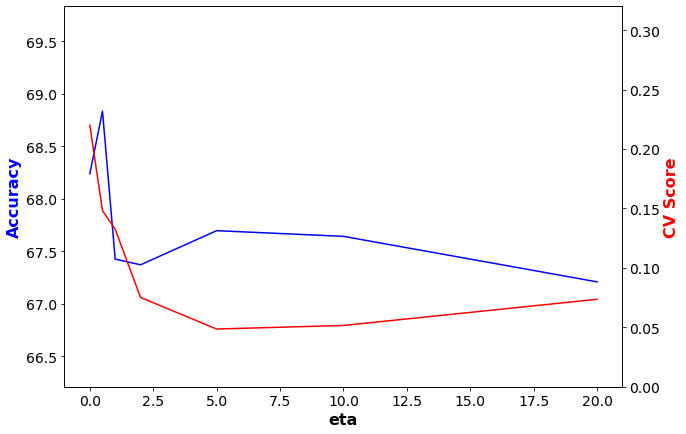

In [ ]:
fairness_plot(eta_value,'eta',acc,"Accuracy",cvs_score,"CV Score") #Graphical Comparison of fairness & performance

In [ ]:
for epoch in range(total_epochs):
  for i in range(max_iter):
    n_feature.d, n_label.d, n_senstive.d = trainloader.next()
    clf_solver.zero_grad()
    clf_sigm.forward(clear_no_need_grad=True)
    output_a = clf_sigm[n_senstive.d == 0]
    output_b = clf_sigm[n_senstive.d == 1]
    PILoss = pr_loss(output_a,output_b,5)
    t_loss = loss + PILoss
    t_loss.forward(clear_no_need_grad=True)
    t_loss.backward(clear_buffer=True)
    clf_solver.update()
test_feature.d, test_label.d,test_senstive.d = testloader.next()
t_clf_out = F.sigmoid(t_clf)
t_clf_out.forward(clear_buffer=True)
y_pre_clf = t_clf_out.d.ravel()
preds = np.where(y_pre_clf > 0.5, 1, 0)
clf_accuracy = metrics.accuracy_score(y_test, preds) * 100
out_a = t_clf_out.d[test_senstive.d == 0]
out_b = t_clf_out.d[test_senstive.d == 1]
cvscore = CVS(out_a,out_b)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


In [ ]:
a = 0
b = 0
for x in out_a:
  if x<0.5:
    a+=1
for x in out_b:
  if x<0.5:
    b+=1

accuracy_AA = a/len(out_a)*100
accuracy_CC = b/len(out_b)*100

print('Total accuracy:',clf_accuracy, 'African American accuracy:',accuracy_AA, 'Caucasian accuracy:',accuracy_CC)

Total accuracy: 67.31707317073172 African American accuracy: 60.418562329390355 Caucasian accuracy: 64.87935656836461
